In [1]:
%load_ext autoreload
%autoreload 2

from statsmodels.base.model import GenericLikelihoodModel

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import sys

from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import multivariate_normal

sys.path.append("../")
import vuong_tests_fast

In [2]:
class JointNormal1(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([params[0], 0.0], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())
    
    
class JointNormal2(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([0.0, params[0]], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())


def setup_shi(yn,xn):
    # model 1 grad, etc.
    nobs = yn.shape[0]
    model1_param = np.array([yn.mean()])
    model2_param = np.array([xn.mean()])
    
    model1_deriv = JointNormal1(yn,xn)
    ll1 = model1_deriv.loglikeobs(model1_param)
    grad1 =  model1_deriv.score_obs(model1_param).reshape( (nobs,1) )
    hess1 = model1_deriv.hessian(model1_param)
    
    
    model2_deriv = JointNormal2(yn,xn)
    ll2 = model2_deriv.loglikeobs(model2_param)
    grad2 =  model2_deriv.score_obs(model2_param).reshape( (nobs,1) )  
    hess2 = model2_deriv.hessian(model2_param)
    
    return ll1,grad1,hess1,model1_param,ll2,grad2,hess2,model2_param

def gen_data(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([beta,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

yn,xn,nobs = gen_data()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi(yn,xn)
print(grad1.shape,hess1.shape)
#NOTE! Weird size distortions with shi's test when theta = .5....

(1000, 1) (1, 1)


In [3]:
nsims= 100
trials=200 #bootstrap subsample size
skip_boot=False
skip_shi=False
refinement_test=True
c11=.02 # bigger with the regular statistic than bootstrap***
c21 = .01

c12 = .005
c22 = .0025

linspace=4
smoothing =1

# Size stuff

In [4]:
betas = np.linspace(0,3,linspace)
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data(nobs=200, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c11,c2=c21)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,refine_test,boot1,boot3)
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])



[1. 0. 0.] [1. 0. 0.] [1. 0. 0.] [1. 0. 0.] [1. 0. 0.]
[0.92 0.01 0.07] [0.98 0.01 0.01] [0.98 0.01 0.01] [0.93 0.07 0.  ] [1. 0. 0.]
[0.92 0.03 0.05] [0.92 0.03 0.05] [0.94 0.03 0.03] [0.92 0.04 0.04] [1. 0. 0.]
[0.93 0.03 0.04] [0.93 0.03 0.04] [0.95 0.02 0.03] [0.92 0.05 0.03] [1. 0. 0.]


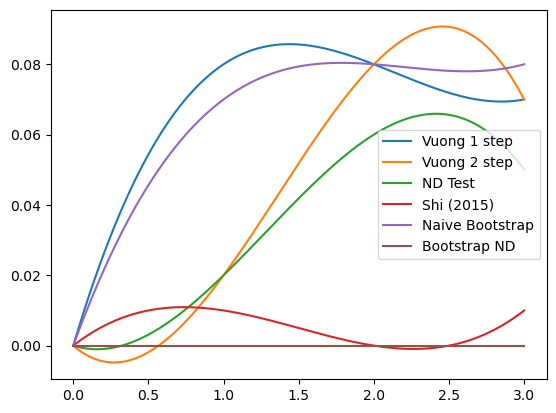

In [5]:
def create_fig(params,res,name='test.png'):
    results2 = np.array(res)
    
    ma2 = lambda x : np.convolve(x,np.ones(smoothing)/smoothing, mode='valid')
    params_new = np.linspace( ma2(params).min(),  ma2(params).max(), 300) 
    interp = lambda x: make_interp_spline(ma2(params), ma2(x), k=3)(params_new)


    plt.plot(params_new, interp(1-results2[:,0,0]) ,label='Vuong 1 step')
    plt.plot(params_new, interp(1-results2[:,1,0]) ,label='Vuong 2 step')
    plt.plot(params_new, interp(1-results2[:,2,0]) ,label='ND Test')
    if not skip_shi:
        plt.plot(params_new,interp(1-results2[:,3,0]),label='Shi (2015)')
    if not skip_boot:
        plt.plot(params_new,interp(1-results2[:,4,0]),label='Naive Bootstrap')
        plt.plot(params_new,interp(1-results2[:,6,0]),label='Bootstrap ND')

    plt.legend()
    plt.savefig('figs/'+name,dpi=300)
    plt.show()

name = 'size1_nims%s_shi%s_skip_boot%s_cstar%s.png'%(nsims,skip_shi,skip_boot,c11)
create_fig(betas,results,name=name)

[1. 0. 0.] [1. 0. 0.] [1. 0. 0.] [1. 0. 0.] [1. 0. 0.]
[0.88 0.   0.12] [1. 0. 0.] [0.9 0.  0.1] [0.87 0.12 0.01] [0.98 0.02 0.  ]
[0.94 0.   0.06] [0.94 0.   0.06] [0.94 0.   0.06] [0.93 0.07 0.  ] [0.98 0.02 0.  ]
[0.96 0.01 0.03] [0.96 0.01 0.03] [0.96 0.01 0.03] [0.97 0.03 0.  ] [0.98 0.02 0.  ]


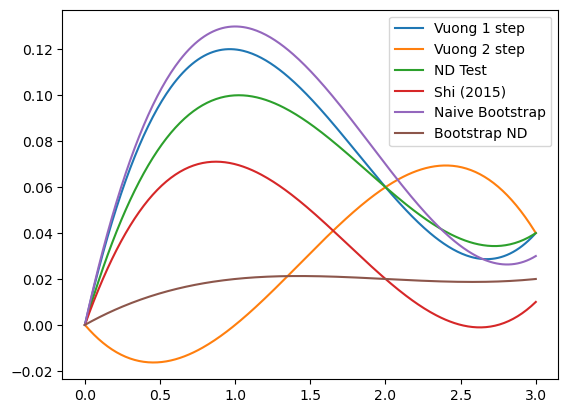

In [6]:
betas = np.linspace(0,3,linspace)
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data(nobs=200, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c12,c2=c22)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,refine_test,boot1,boot3)
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])
    
name = 'size1_nims%s_shi%s_skip_boot%s_cstar%s.png'%(nsims,skip_shi,skip_boot,c11)
create_fig(betas,results,name=name)

# alternate DGP

In [7]:
class OLS_loglike(GenericLikelihoodModel):
    
    def __init__(self, *args,ols=False, **kwargs):
        super(OLS_loglike,self).__init__(*args,**kwargs)
        self.ols = ols

    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        mu_y = np.matmul(x,params)  
        resid = y - mu_y
        sigma = np.sqrt(np.sum(resid**2)/resid.shape[0])
        pr_y = stats.norm.logpdf( resid, loc=0,scale=sigma )
        return pr_y


def setup_shi2(yn,xn,return_model=False,num_params=4):
    x1n,x2n = xn[:,0],xn[:,1:num_params]
    
    # model 1 grad, etc.
    model1 = sm.OLS(yn,sm.add_constant(x1n))
    model1_fit = model1.fit(disp=False)
    params1 = (model1_fit.params)
    
    model1_deriv = OLS_loglike(yn,sm.add_constant(x1n))
    ll1 = model1_deriv.loglikeobs(model1_fit.params)
    grad1 =  model1_deriv.score_obs(model1_fit.params)    
    hess1 = model1_deriv.hessian(model1_fit.params)
    
    #model 2 grad, etc.
    model2 = sm.OLS(yn,sm.add_constant(x2n))
    model2_fit = model2.fit(disp=False)
    params2 = (model2_fit.params)
    
    model2_deriv = OLS_loglike(yn,sm.add_constant(x2n))
    ll2 = model2_deriv.loglikeobs(model2_fit.params)
    grad2 =  model2_deriv.score_obs(model2_fit.params)    
    hess2 = model2_deriv.hessian(model2_fit.params)
    
    if return_model:
        return ll1,grad1,hess1,params1,model1,ll2,grad2,hess2,params2,model2
    return ll1,grad1,hess1,params1,ll2,grad2,hess2,params2

def gen_data2(nobs=1000, a=0.25, num_params=4):
    x = np.random.normal(scale=1., size=(nobs,1+num_params))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1 + a*x[:,0] + a/np.sqrt(num_params)*x[:,1:num_params+1].sum(axis=1) + e
    return y,x,nobs

yn,xn,nobs = gen_data2()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi2(yn,xn,return_model=False,num_params=15)
print(grad1.shape,hess1.shape)

(1000, 2) (2, 2)


[0.91 0.   0.09] [1. 0. 0.] [0.95 0.   0.05] [0.92 0.08 0.  ] [1. 0. 0.]
[1. 0. 0.] [1. 0. 0.] [1. 0. 0.] [1. 0. 0.] [1. 0. 0.]
[0.94 0.03 0.03] [0.94 0.03 0.03] [0.95 0.02 0.03] [0.94 0.04 0.02] [0.97 0.01 0.02]
[0.94 0.02 0.04] [0.94 0.02 0.04] [0.95 0.02 0.03] [0.95 0.03 0.02] [0.98 0.   0.02]


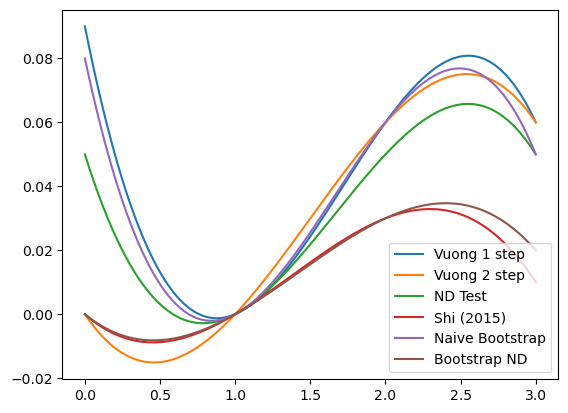

In [8]:
a = np.linspace(0,3,linspace)
results = []
num_params=9

for a1 in a:
    setup_shi_ex  = lambda yn,xn: setup_shi2(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data2(nobs=100, a=a1,  num_params=num_params)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c11,c2=c21)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,refine_test,boot1,boot3)
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

name = 'size2_nims%s_shi%s_skip_boot%s_cstar%s.png'%(nsims,skip_shi,skip_boot,c11)
create_fig(a,results,name=name)

[0.94 0.   0.06] [1. 0. 0.] [0.94 0.   0.06] [0.93 0.07 0.  ] [1. 0. 0.]
[0.94 0.03 0.03] [0.94 0.03 0.03] [0.94 0.03 0.03] [0.94 0.04 0.02] [0.93 0.01 0.06]
[0.93 0.03 0.04] [0.93 0.03 0.04] [0.94 0.02 0.04] [0.93 0.04 0.03] [0.94 0.01 0.05]
[0.93 0.06 0.01] [0.93 0.06 0.01] [0.93 0.06 0.01] [0.91 0.02 0.07] [0.89 0.   0.11]


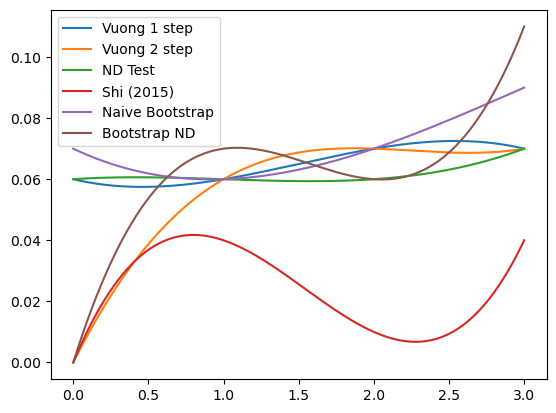

In [9]:
a = np.linspace(0,3,linspace)
results = []
num_params=9

for a1 in a:
    setup_shi_ex  = lambda yn,xn: setup_shi2(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data2(nobs=100, a=a1,  num_params=num_params)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c12,c2=c22)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,refine_test,boot1,boot3)
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])


name = 'size2_nims%s_shi%s_skip_boot%s_cstar%s.png'%(nsims,skip_shi,skip_boot,c12)
create_fig(a,results,name=name)

# Power stuff

[1. 0. 0.] [1. 0. 0.] [1. 0. 0.] [1. 0. 0.] [1. 0. 0.]
[0.39 0.   0.61] [1. 0. 0.] [0.72 0.   0.28] [0.41 0.59 0.  ] [1. 0. 0.]
[0.02 0.   0.98] [0.99 0.   0.01] [0.02 0.   0.98] [0.02 0.98 0.  ] [0.94 0.06 0.  ]
[0. 0. 1.] [0.81 0.   0.19] [0. 0. 1.] [0. 1. 0.] [0.19 0.81 0.  ]


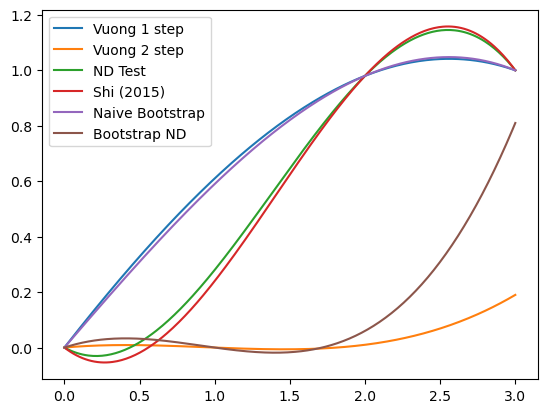

In [10]:

def gen_data3(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([0,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

betas = np.linspace(0,3,linspace)
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
    gen_data_ex = lambda : gen_data3(nobs=100, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c11,c2=c21)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,refine_test,boot1,boot3)
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

name = 'power_nims%s_shi%s_skip_boot%s_cstar%s.png'%(nsims,skip_shi,skip_boot,c11)
create_fig(betas,results,name=name)

[1. 0. 0.] [1. 0. 0.] [1. 0. 0.] [1. 0. 0.] [1. 0. 0.]
[0.47 0.   0.53] [1. 0. 0.] [0.52 0.   0.48] [0.47 0.53 0.  ] [0.93 0.07 0.  ]
[0.03 0.   0.97] [0.97 0.   0.03] [0.03 0.   0.97] [0.03 0.97 0.  ] [0.07 0.93 0.  ]
[0. 0. 1.] [0.89 0.   0.11] [0. 0. 1.] [0. 1. 0.] [0. 1. 0.]


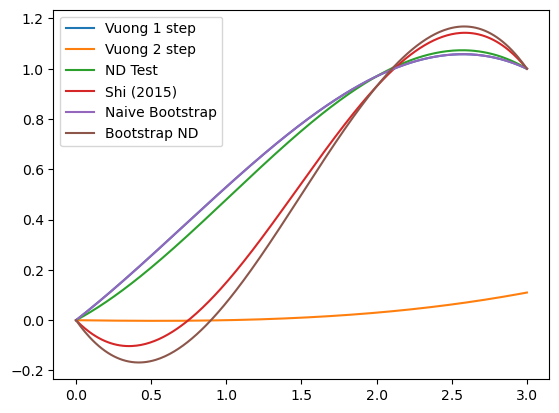

In [11]:
betas = np.linspace(0,3,linspace)
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
    gen_data_ex = lambda : gen_data3(nobs=100, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c12,c2=c22)
    reg,twostep, refine_test,boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,refine_test,boot1,boot3)
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

name = 'power_nims%s_shi%s_skip_boot%s_cstar%s.png'%(nsims,skip_shi,skip_boot,c12)
create_fig(betas,results,name=name)